In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,r2_score,root_mean_squared_error

In [2]:
df = pd.read_csv("Crop_recommendation.csv")
df.info()
print(f"\nShape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Shape: (2200, 8)


In [3]:
df = df.rename(columns={'label': 'target'})

In [13]:
df.info()
print(f"\nShape: {df.shape}")

print(f"humidity max {df['humidity'].max()}")
print(f"humidity min {df['humidity'].min()}")

print(f"ph min {df['ph'].min()}")
print(f"ph max {df['ph'].max()}")

print(f"rainfall min {df['rainfall'].min()}")
print(f"rainfall max {df['rainfall'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   target       2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Shape: (2200, 8)
humidity max 99.98187601
humidity min 14.25803981
ph min 3.504752314
ph max 9.93509073
rainfall min 20.21126747
rainfall max 298.5601175


In [5]:
X = df.drop('target', axis=1)
y = df['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [6]:
models = {"log_reg": LogisticRegression(max_iter=100000, n_jobs=1),
          "desc_tree": DecisionTreeClassifier(random_state=42),
          "rand_forest": RandomForestClassifier(random_state=42),
          "svm": SVC(random_state=42)}

import time

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

r2   = r2_score
rmse = root_mean_squared_error
acc  = accuracy_score

for name, model in models.items():
    print(f"\n Nu tränas {name}")
    start_time = time.time()
    model.fit(X_train_scaled,y_train)

    val_pred = model.predict(X_val_scaled)
    acc  = accuracy_score(y_val,val_pred)

    train_time = (time.time() - start_time)

    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation accuracy: {acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")
    





 Nu tränas log_reg


Training time: 0.31 seconds
Validation accuracy: 0.9682
Test accuracy: 0.9614

 Nu tränas desc_tree
Training time: 0.11 seconds
Validation accuracy: 0.9750
Test accuracy: 0.9750

 Nu tränas rand_forest
Training time: 1.24 seconds
Validation accuracy: 0.9955
Test accuracy: 0.9909

 Nu tränas svm
Training time: 0.48 seconds
Validation accuracy: 0.9841
Test accuracy: 0.9636



log_reg CV Score: 0.9689 (+/- 0.0130)

desc_tree CV Score: 0.9909 (+/- 0.0061)

rand_forest CV Score: 0.9947 (+/- 0.0077)

svm CV Score: 0.9848 (+/- 0.0068)


<Figure size 1000x1000 with 0 Axes>

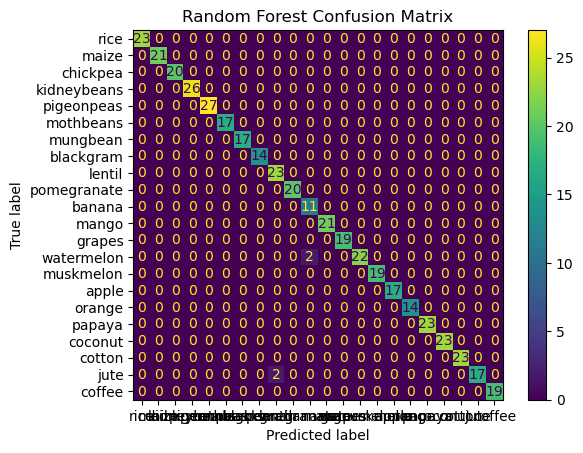

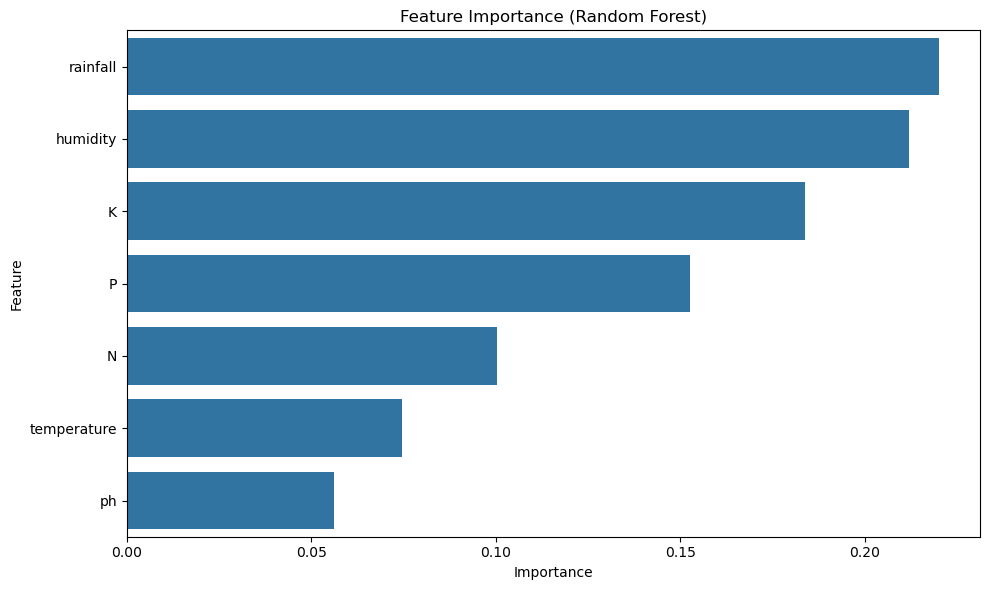

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"\n{name} CV Score: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# 2. Confusion Matrix for best model (Random Forest)
best_model = models['rand_forest']
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['target'].unique())
plt.figure(figsize=(10, 10))
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# 3. Feature Importance (for Random Forest)
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
importance = importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [14]:
import os 
import joblib

os.makedirs('models', exist_ok=True)


model_path = os.path.join('models', 'random_forest_crop.joblib')
joblib.dump(models['rand_forest'], model_path)


scaler_path = os.path.join('models', 'scaler.joblib')
joblib.dump(scaler, scaler_path)

['models/scaler.joblib']